# Mesoscale Mixing

1. Mesoscale Phenomenology
1. Reynolds Fluxes in Ocean and Climate
1. Quantifying and Parameterizing Eddy Transport
  1. Diffusion
  1. Advection
1. Measuring Eddy Diffusion


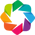

In [45]:
import xarray as xr
from matplotlib import pyplot as plt
import seaborn
import numpy as np
import gsw
import pandas as pd
import dask.dataframe as dask_df
import dask.array as dsa
import datashader

seaborn.set(font_scale=2)
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,7)
from IPython.display import SVG, display, Image, display_svg, HTML
import holoviews as hv
hv.extension('bokeh')


## Space and Time Scales of Ocean Processes
![space and time scales](mesoscale_images/space_time_scales.png)
Image Credit: [Report of the High-Resolution Ocean Topography Science Working Group Meeting, 2011. Ed. Dudley Chelton](http://www-po.coas.oregonstate.edu/~poa/www-po/research/po/research/hotswg/HOTSWG_overview.pdf)

## Mesoscale Phenomenology


<video controls src="https://svs.gsfc.nasa.gov/vis/a000000/a003800/a003827/perpetual_ocean_1080p30.mp4" width="100%" />

credit: [NASA/Goddard Space Flight Center Scientific Visualization Studio](https://svs.gsfc.nasa.gov/3827)

<video controls src="https://www.gfdl.noaa.gov/video/cm26_v5_sst.mp4" width="100%" />

credit: [NOAA/GFDL](https://www.gfdl.noaa.gov/visualization/)

## Eulerian View: Eddies as Variance

We separate the fluctuations into a time mean component and a fluctuation (indicated by prime).

$$\mathbf{u} = \overline{\mathbf{u}} + \mathbf{u}'$$

The time mean might still include seasonal variations. It could also involve spatial smoothing. The most important property of this average is that the fluctuation's average is zero:

$$ \overline{\mathbf{u}'} = 0 $$


## Eddy Kinetic Energy

A fundamental metric of mesoscale variability:

$$ EKE = \frac{1}{2} \overline{\mathbf{u}'^2} 
= \frac{1}{2}( \overline{u'^2} + \overline{v'^2} ) $$



## Measuring Ocean Currents with Drifters

![GDP drifter](http://www.aoml.noaa.gov/phod/dac/drifterschematic.gif)

![GDP drifter](http://www.aoml.noaa.gov/phod/dac/drifterpic1.jpg)

![GDP drifters](http://www.aoml.noaa.gov/phod/graphics/dacdata/globpop_countries.gif)

![GDP drifter movie](http://www.aoml.noaa.gov/phod/graphics/dacdata/movie_array_10-15.gif)

In [ ]:
# download GDP data
! curl -O ftp://ftp.aoml.noaa.gov/pub/phod/buoydata/buoydata_1_5000.dat.gz
! gunzip buoydata_1_5000.dat.gz
! curl -O ftp://ftp.aoml.noaa.gov/pub/phod/buoydata/header_buoydata.txt

In [43]:
with open('header_buoydata.txt') as f:
    header = f.readline()
cols = header.strip().split(',')
# fix bad items
cols[1:4] = ['MM','DD.dd','YYYY']

# special date parser for silly drifter format
def parse_date(m, d, y):
    m = m.astype('i4')
    d = d.astype('f4')
    y = y.astype('i4')
    day = d // 1
    hour = (24 * (d % 1)).astype('i4')
    return [pd.datetime(*args) for args in zip(y, m, day, hour)]

df = dask_df.read_csv('buoydata_1_5000.dat',  sep='\s+', header=None, names=cols,
                 na_values='999.999',
                 parse_dates={'date': [1,2,3]}, date_parser=parse_date)

#rename annoying columns
df = df.rename(columns={'VE(CM/S)': 'U', 'VN(CM/S)': 'V', 'SST(Deg C)': 'SST'})


In [44]:
df.head()

date       ID    Lat      Lon     SST       U       V  \
0 1988-03-08 00:00:00  7702986 -1.320  274.848  25.473     NaN     NaN   
1 1988-03-08 06:00:00  7702986 -1.242  274.772  25.224 -49.214  36.778   
2 1988-03-08 12:00:00  7702986 -1.176  274.657  25.095 -57.514  28.439   
3 1988-03-08 18:00:00  7702986 -1.131  274.548  25.545 -48.625  28.747   
4 1988-03-09 00:00:00  7702986 -1.064  274.468  25.870 -50.787  34.399   

   SPD(CM/S)   VAR.LAT   VAR.LON  VAR.TEMP  
0        NaN  0.000025  0.000034  0.004518  
1     61.438  0.000058  0.000087  0.007215  
2     64.161  0.000020  0.000026  0.005613  
3     56.487  0.000049  0.000072  0.005837  
4     61.340  0.000004  0.000006  0.003111

In [46]:
# use datashader to average the data
canvas = datashader.Canvas(plot_width=180, plot_height=70, x_range=(0, 360), y_range=(-70, 70))
glyph = datashader.glyphs.Point('Lon', 'Lat')
reduction_mean = lambda col_name: ds.reductions.mean(col_name)
reduction_var = lambda col_name: ds.reductions.var(col_name)

agg_Umean = datashader.core.bypixel(df, canvas, glyph, reduction_mean('U'))
agg_Uvar = datashader.core.bypixel(df, canvas, glyph, reduction_var('U'))
agg_Vmean = datashader.core.bypixel(df, canvas, glyph, reduction_mean('V'))    
agg_Vvar = datashader.core.bypixel(df, canvas, glyph, reduction_var('V'))

/Users/rpa/miniconda3/envs/geo_scipy/lib/python3.6/site-packages/datashader/reductions.py:223: RuntimeWarning: invalid value encountered in true_divide
  mu = np.nansum(sums, axis=0) / ns.sum(axis=0)
/Users/rpa/miniconda3/envs/geo_scipy/lib/python3.6/site-packages/datashader/reductions.py:223: RuntimeWarning: invalid value encountered in true_divide
  mu = np.nansum(sums, axis=0) / ns.sum(axis=0)


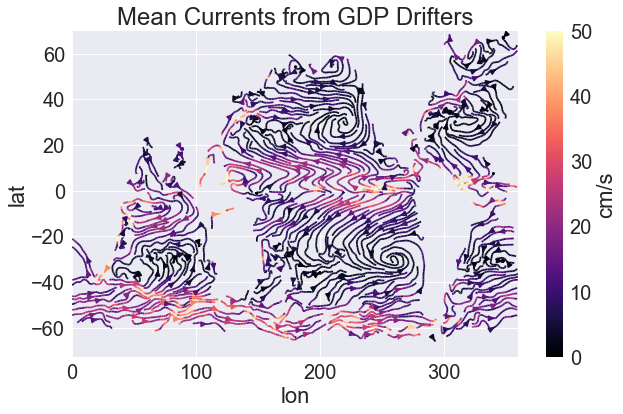

In [53]:
from matplotlib.colors import Normalize
fig, ax = plt.subplots(figsize=(10,6))
x, y = agg_Umean.x_axis.data, agg_Umean.y_axis.data
u, v = agg_Umean.data, agg_Vmean.data
sp = ax.streamplot(x, y, u, v,
                  color=(u**2 + v**2)**0.5,
                  cmap='magma', norm=Normalize(vmin=0, vmax=50),
                  density=4)
cb = plt.colorbar(sp.lines)
cb.set_label('cm/s')
ax.set_xlabel('lon')
ax.set_ylabel('lat')
ax.set_title('Mean Currents from GDP Drifters')

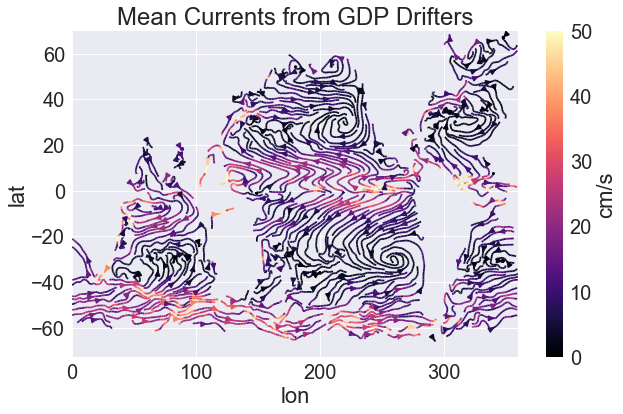

In [55]:
fig

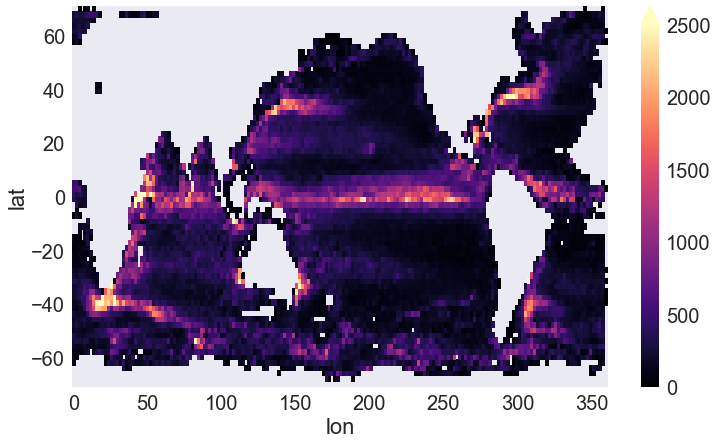

In [70]:
EKE = 0.5*(agg_Uvar + agg_Vvar).rename({'y_axis': 'lat', 'x_axis': 'lon'})
fig, ax = plt.subplots()
EKE.plot(cmap='magma', vmax=2500, ax=ax);

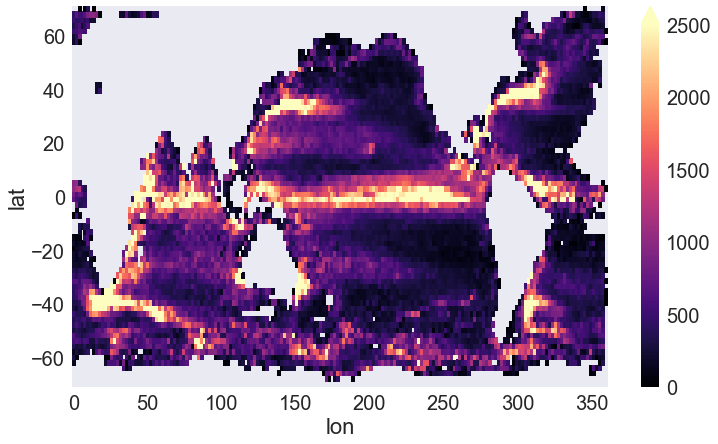

In [69]:
fig

In [2]:
df = pd.read_csv('https://tinyurl.com/okubo1971')
# convert cm to m
df.sigma_rc /= 100
# add derived fields
df['sigma_rc2'] = df.sigma_rc**2
df['K_a'] = 0.25 * df.sigma_rc2 / df.t
df['l'] = 3*df.sigma_rc
df.head()

experiment          t  sigma_rc note    sigma_rc2  \
0  RHENO (1956) North Sea (Aug.-Sept.)   270000.0    2470.0  NaN    6100900.0   
1  RHENO (1956) North Sea (Aug.-Sept.)   486000.0    4530.0  NaN   20520900.0   
2  RHENO (1956) North Sea (Aug.-Sept.)   810000.0    6930.0  NaN   48024900.0   
3  RHENO (1956) North Sea (Aug.-Sept.)   973000.0   10400.0  NaN  108160000.0   
4  RHENO (1956) North Sea (Aug.-Sept.)  1220000.0   12200.0  NaN  148840000.0   

         K_a        l  
0   5.648981   7410.0  
1  10.556019  13590.0  
2  14.822500  20790.0  
3  27.790339  31200.0  
4  30.500000  36600.0

In [3]:
%%opts Scatter [width=700 height=600 color_index=2 show_grid=True logx=True logy=True tools=['hover'], show_legend=False] 
%%opts Scatter (cmap='tab20' size=10 line_color='k')
%%opts NdOverlay [legend_position='left' show_frame=False fontsize=8]

key_dimensions = [('t', 'time (seconds)')]
value_dimensions = ['sigma_rc2', 'K_a', 'experiment']
macro = hv.Table(df, kdims=key_dimensions, vdims=value_dimensions)
scatter = macro.to.scatter(kdims='t', vdims=['sigma_rc2', 'experiment'], label='Dispersion (Okubo, 1971)')

In [4]:
scatter

:Scatter   [t]   (sigma_rc2,experiment)

In [5]:
%%opts Scatter [width=700 height=600 color_index=2 show_grid=True logx=True logy=True tools=['hover'], show_legend=False] 
%%opts Scatter (cmap='tab20' size=10 line_color='k')
%%opts NdOverlay [legend_position='left' show_frame=False fontsize=8]

key_dimensions = [('l', 'length scale (m)')]
value_dimensions = ['sigma_rc2', ('K_a', 'K (m^2/s)'), 'experiment']
macro = hv.Table(df, kdims=key_dimensions, vdims=value_dimensions)
scatter = macro.to.scatter(kdims='l', vdims=['K_a', 'experiment'], label='Diffusion (Okubo, 1971)')

In [6]:
scatter

:Scatter   [l]   (K_a,experiment)

In [7]:
import holoviews as hv
import geoviews as gv
import datashader as ds

from bokeh.models import WMTSTileSource
from cartopy import crs
from matplotlib.cm import get_cmap
from holoviews.operation.datashader import datashade, aggregate

from dask.diagnostics import ProgressBar
from dask.cache import Cache

/Users/rpa/miniconda3/envs/geo_scipy/lib/python3.6/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)
/Users/rpa/miniconda3/envs/geo_scipy/lib/python3.6/site-packages/odo/backends/pandas.py:102: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access NaTType as type(pandas.NaT)
  @convert.register((pd.Timestamp, pd.Timedelta), (pd.tslib.NaTType, type(None)))


In [8]:
dataset = gv.Dataset(df, kdims=['Lon', 'Lat'])
dataset

:Dataset   [Lon,Lat]   (date,ID,SST(Deg C),U,V,SPD(CM/S),VAR.LAT,VAR.LON,VAR.TEMP,KE)

In [14]:
x_range, y_range = ((0, 360), (-70, 70)) # Continental USA
shade_defaults = dict(x_range=x_range, y_range=y_range, x_sampling=0.25, y_sampling=0.25, width=1200, height=660)

shaded = datashade(gv.Points(dataset), aggregator=ds.mean('U'), **shade_defaults)

In [15]:
%%opts RGB [width=800 height=600]
shaded

:DynamicMap   []

In [23]:
dataset

:Dataset   [Lon,Lat]   (date,ID,SST(Deg C),U,V,SPD(CM/S),VAR.LAT,VAR.LON,VAR.TEMP,KE)

In [18]:
canvas = ds.Canvas(plot_width=180, plot_height=70, x_range=(0, 360), y_range=(-70, 70))
glyph = ds.glyphs.Point('Lon', 'Lat')
reduction_mean = lambda col_name: ds.reductions.mean(col_name)
reduction_var = lambda col_name: ds.reductions.var(col_name)

from datashader.core import bypixel
agg_Umean = bypixel(df, canvas, glyph, reduction_mean('U'))
agg_Uvar = bypixel(df, canvas, glyph, reduction_var('U'))
agg_Vmean = bypixel(df, canvas, glyph, reduction_mean('V'))    
agg_Vvar = bypixel(df, canvas, glyph, reduction_var('V'))

In [17]:
agg_Vmean

<xarray.DataArray (y_axis: 600, x_axis: 800)>
array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ..., 
       [ -3.115422,  10.611739,   6.705846, ...,  -5.873179, -11.318733,
               nan],
       [  0.788927,   6.815102,  13.828222, ...,  -6.704566,  -3.502778,
               nan],
       [       nan,        nan,        nan, ...,  -5.8985  ,        nan,
               nan]])
Coordinates:
  * y_axis   (y_axis) float64 -70.0 -69.77 -69.53 -69.3 -69.07 -68.83 -68.6 ...
  * x_axis   (x_axis) float64 0.0 0.4506 0.9011 1.352 1.802 2.253 2.703 ...

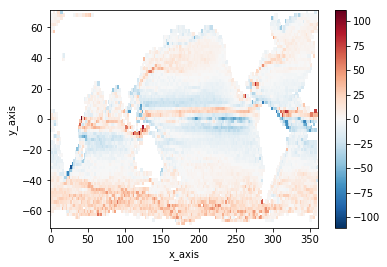

In [21]:
agg_Umean.plot()

In [ ]:
U = agg_U.values
V = agg_V.values
X, Y = np.meshgrid(agg_U.x_axis, agg_U.y_axis)

mag = np.sqrt(U**2 + U**2)
mag = np.sqrt(U**2 + V**2)
angle = (np.pi/2.) - np.arctan2(U/mag, V/mag)
hv.VectorField((X.flat, Y.flat, angle.flat, mag.flat))

In [46]:
xs, ys = np.arange(0, 2 * np.pi, .2), np.arange(0, 2 * np.pi, .2)
X, Y = np.meshgrid(xs, ys)
U = np.cos(X)
V = np.sin(Y)

In [47]:
%%opts VectorField [width=500]
mag = np.sqrt(U**2 + V**2)
angle = (np.pi/2.) - np.arctan2(U/mag, V/mag)
hv.VectorField((X.flat, Y.flat, angle.flat, mag.flat)).relabel('Arrows scale with plot width, not view')

:VectorField   [x,y]   (Angle,Magnitude)

In [49]:
for d in [X, Y, angle, mag]:
    print(type(d))
    print(d.shape)

<class 'numpy.ndarray'>
(32, 32)
<class 'numpy.ndarray'>
(32, 32)
<class 'numpy.ndarray'>
(32, 32)
<class 'numpy.ndarray'>
(32, 32)


In [38]:
## Works but doesn't look good

#xx, yy = np.meshgrid(x, y)
#mag = np.sqrt(u**2 + v**2)
#angle = (np.pi/2.) - np.arctan2(u/mag, v/mag)
#hv.VectorField((xx.flat, yy.flat, mag.flat, angle.flat))

In [ ]:
plt.cl